In [15]:
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf

from tensorflow import keras

dataset_dir = pathlib.Path('data')
batch_size = 32
img_width = 180
img_height = 180

In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2, 
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2, 
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = len(class_names)

Found 3149 files belonging to 2 classes.
Using 2520 files for training.
Found 3149 files belonging to 2 classes.
Using 629 files for validation.
Class names: ['man', 'woman']


In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(img_height, img_width)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomZoom(0.2),
    
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'), 
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'), 
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'), 
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 180, 180, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                      

In [24]:
epochs = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
79/79 [==============================] - 28s 337ms/step - loss: 0.7699 - accuracy: 0.5675 - val_loss: 0.6597 - val_accuracy: 0.5978
Epoch 2/10
79/79 [==============================] - 27s 336ms/step - loss: 0.6579 - accuracy: 0.5992 - val_loss: 0.6458 - val_accuracy: 0.6057
Epoch 3/10
79/79 [==============================] - 26s 332ms/step - loss: 0.6545 - accuracy: 0.6250 - val_loss: 0.6782 - val_accuracy: 0.5898
Epoch 4/10
79/79 [==============================] - 26s 334ms/step - loss: 0.6393 - accuracy: 0.6484 - val_loss: 0.6195 - val_accuracy: 0.6725
Epoch 5/10
79/79 [==============================] - 26s 329ms/step - loss: 0.6177 - accuracy: 0.6587 - val_loss: 0.6015 - val_accuracy: 0.6550
Epoch 6/10
79/79 [==============================] - 26s 332ms/step - loss: 0.6015 - accuracy: 0.6774 - val_loss: 0.6153 - val_accuracy: 0.7027
Epoch 7/10
79/79 [==============================] - 26s 333ms/step - loss: 0.5935 - accuracy: 0.6865 - val_loss: 0.5771 - val_accuracy: 0.6789

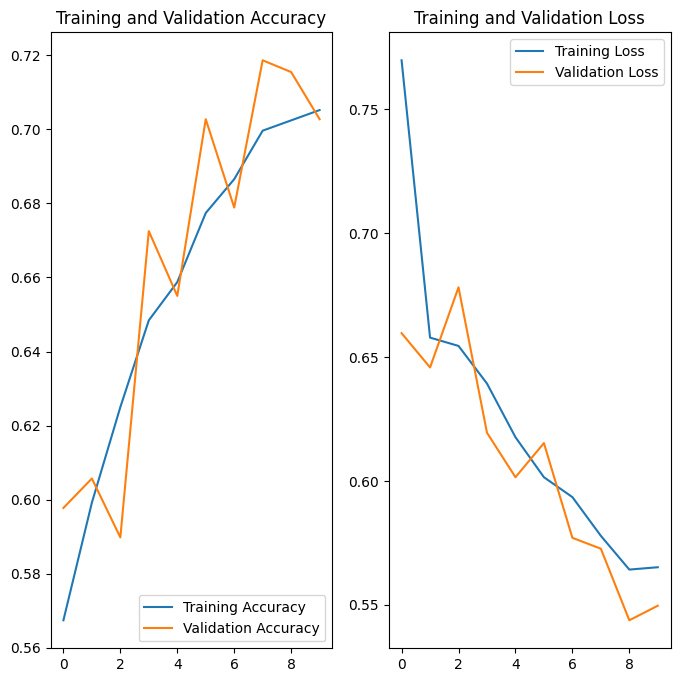

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
model.save_weights('saved_model')

In [31]:
img = tf.keras.utils.load_img('фото.png', target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
prediction = model.predict(img_array)
score = tf.nn.softmax(prediction[0])
print(f'I think it is {class_names[np.argmax(score)]} (probability {100 * np.max(score)}%)')

1/1 [==============================] - 0s 33ms/step
I think it is man (probability 91.30840301513672%)
